In [1]:
import time
import numpy as np
import math
from numba import cuda, float32
import matplotlib.pyplot as plt

In [2]:
@cuda.jit
def is_prime(data_in, data_out):
    idx = cuda.grid(1)
    if idx < data_in.size:
        number = data_in[idx]
        if number < 2:
            data_out[idx] = 0
        else:
            is_prime = True
            for i in range(2, int(math.sqrt(number))+1):
                if number % i == 0:
                    is_prime = False
                    break
            data_out[idx] = 1 if is_prime else 0
            
def is_prime_cpu(numbers):
    is_prime_array = np.zeros_like(numbers)
    for i in range(numbers.size):
        number = numbers[i]
        if number < 2:
            is_prime_array[i] = 0
        else:
            is_prime = True
            for j in range(2, int(math.sqrt(number))+1):
                if number % j == 0:
                    is_prime = False
                    break
            is_prime_array[i] = 1 if is_prime else 0
    return is_prime_array

Tengo el codigo para que corra el descubrimiento de primos en GPU y en CPU. 
Se generan n cantidad de numeros a evaluar, eso se manda a procesar primero por cpu en un solo nucleo y despues por gpu. 
Se toman los tiempos y se comparan. 
Para que esto funcione es necesario generar una array de numeros al azar el cual va a ser evaluado por si el numero random que se genera es o no un primo.

In [1]:
# Set the size of the array
n = 10**6
# Create the input and output arrays
data_in = np.random.randint(2, n, n).astype(np.int32)
data_in_cpu=data_in
data_out = np.zeros_like(data_in)

#Mido la performance en CPU

start_time = time.time()
is_prime_array_cpu = is_prime_cpu(data_in_cpu)
end_time = time.time()
total_time_cpu = end_time - start_time

#Seteo lo necesario para que el array pueda ser pasado a bloques de memoria de la GPU
# Set the number of threads per block and the number of blocks per grid
threads_per_block = 128
blocks_per_grid = (n + (threads_per_block - 1)) // threads_per_block

# Allocate memory on the GPU
d_data_in = cuda.to_device(data_in)
d_data_out = cuda.to_device(data_out)

# Measure the time of the kernel
start_time = time.time()
is_prime[blocks_per_grid, threads_per_block](d_data_in, d_data_out)
cuda.synchronize()
end_time = time.time()

# Copy the results back to the CPU
d_data_out.copy_to_host(data_out)

# Measure the total time
total_time = time.time() - start_time

print("Number of primes evaluated:", n)
print("Number of primes found by GPU:", np.sum(data_out))
print("Number of primes found by CPU:", np.sum(is_prime_array_cpu))

print("Kernel execution time (GPU):", total_time)
print("Execution time (CPU):", total_time_cpu)



Number of primes evaluated: 1000000
Number of primes found by GPU: 78852
Number of primes found by CPU: 78852
Kernel execution time (GPU): 0.17670440673828125
Execution time (CPU): 68.76792669296265


Esta funcionando bastante bien unificado, ahora voy a sacar metricas para ver como funciona esto usando varion n y haciendo algunos graficos que me permitan visualizarlo.

/home/maxpower/anaconda3/envs/numba_env/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 79 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


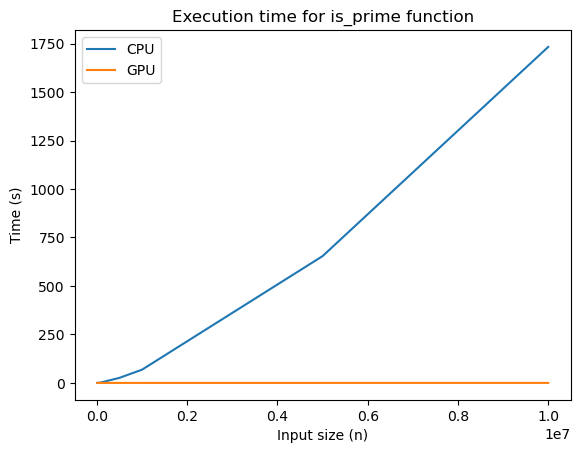

In [3]:
# Set the sizes of the arrays to test
n_values = [10**4, 5*10**4, 10**5, 5*10**5,10**6, 5*10**6, 10**7]

gpu_times = []
cpu_times = []

for n in n_values:
    # Generate the input array
    data_in = np.random.randint(2, n, n).astype(np.int32)

    # Run the CPU version of the function and measure the time
    start_time = time.time()
    is_prime_cpu(data_in)
    cpu_times.append(time.time() - start_time)

    # Set the number of threads per block and the number of blocks per grid
    threads_per_block = 128
    blocks_per_grid = (n + (threads_per_block - 1)) // threads_per_block

    # Allocate memory on the GPU
    d_data_in = cuda.to_device(data_in)
    d_data_out = cuda.to_device(np.zeros_like(data_in))

    # Run the GPU version of the function and measure the time
    start_time = time.time()
    is_prime[blocks_per_grid, threads_per_block](d_data_in, d_data_out)
    cuda.synchronize()
    gpu_times.append(time.time() - start_time)

# Plot the results
plt.plot(n_values, cpu_times, label='CPU')
plt.plot(n_values, gpu_times, label='GPU')
plt.title('Execution time for is_prime function')
plt.xlabel('Input size (n)')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

Vuelvo a correr pero ahora solo GPU para ver la performance sola y aumento hasta el limite

Total memory used by GPU with 100000000 elements: 1212.6875 MB
Total memory used by GPU with 200000000 elements: 2740.6875 MB
Total memory used by GPU with 400000000 elements: 5792.6875 MB
Total memory used by GPU with 600000000 elements: 5028.6875 MB
Total memory used by GPU with 800000000 elements: 11132.6875 MB
Total memory used by GPU with 1000000000 elements: 11132.6875 MB
Total memory used by GPU with 2000000000 elements: 19524.6875 MB


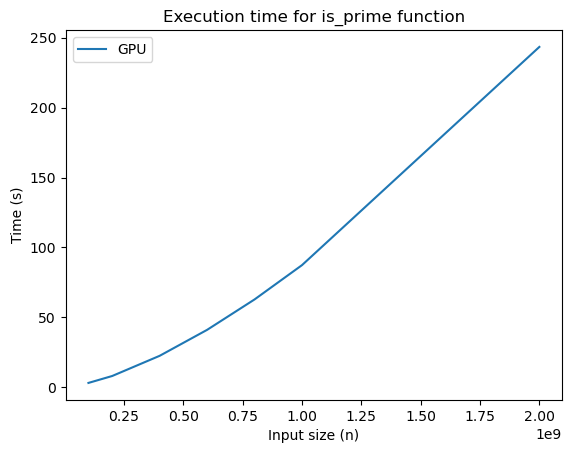

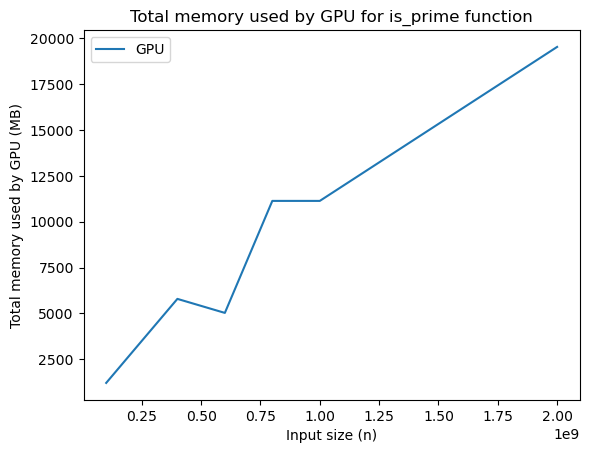

In [3]:
# Set the sizes of the arrays to test

#Pruebas_generales
#n_values = [10**4, 5*10**4, 10**5, 5*10**5,10**6, 5*10**6, 10**7]

#Mas alla de 10**9, se rompe por la transferencia de memoria
#n_values = [10**5, 5*10**5, 10**6, 5*10**6,10**7, 5*10**7, 10**8, 5*10**8 ,10**9]

#Busco el limite para que consuma toda la RAM posible
n_values = [10**8, 2*10**8, 4*10**8, 6*10**8, 8*10**8 , 10**9, 2*10**9]
gpu_times = []
#cpu_times = []
mem_use=[]
for n in n_values:
    # Generate the input array
    data_in = np.random.randint(2, n, n).astype(np.int32)

    # Run the CPU version of the function and measure the time
    #start_time = time.time()
    #is_prime_cpu(data_in)
    #cpu_times.append(time.time() - start_time)

    # Set the number of threads per block and the number of blocks per grid
    threads_per_block = 128
    blocks_per_grid = (n + (threads_per_block - 1)) // threads_per_block

    # Allocate memory on the GPU
    d_data_in = cuda.to_device(data_in)
    d_data_out = cuda.to_device(np.zeros_like(data_in))

    # Run the GPU version of the function and measure the time
    start_time = time.time()
    is_prime[blocks_per_grid, threads_per_block](d_data_in, d_data_out)
    #cuda.current_context().get_memory_info()  genera una tuppla de espacio libre = [0] y total =[1]. Divido por 1024/1024 para tener MB
    memory_use=(cuda.current_context().get_memory_info()[1]/1024/1024 - cuda.current_context().get_memory_info()[0]/1024/1024)
    print("Total memory used by GPU with",n,"elements:",memory_use,"MB")
    cuda.synchronize()
    gpu_times.append(time.time() - start_time)
    mem_use.append(memory_use)


# Plot the results
#plt.plot(n_values, cpu_times, label='CPU')
plt.plot(n_values, gpu_times, label='GPU')
plt.title('Execution time for is_prime function')
plt.xlabel('Input size (n)')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

plt.plot(n_values, mem_use, label='GPU')
plt.title('Total memory used by GPU for is_prime function')
plt.xlabel('Input size (n)')
plt.ylabel('Total memory used by GPU (MB)')
plt.legend()
plt.show()